# KR1: DLA Serial Implementation

In [1]:
using Plots
using BenchmarkTools
using DelimitedFiles
using Distributions
using GLM
using DataFrames
using Polynomials

include("Julia_serialized_DLA/serialized_dla_modules.jl")
include("Julia_parallelized_DLA/parallelized_DLA.jl")

include("Julia_serialized_DLA/time_complexity_module.jl")
include("Julia_serialized_DLA/fractal_dimension_module.jl")

Main.fractal_dimension

## KR1a: `.jl` functions

A set of functions that can generate a single instance of a walker with a random initial position, doing a random walk across the square lattice

### Serial DLA Algorithm

The main function to create a DLA.

In [2]:
? Random_walker.serialized_dla()

# Description

Constructs a cluster aggregate with particle number, `particle_number`, and a maximum radius of `maximum_radius`. Each particle has the probability of sticking on the cluster p = `sticking_prob`.

## Args

```
particle_number (Int64): number of particles used to build the cluster
maximum_radius (Float64): maximum radius the death circle and the birth 
    circle can grow into.
sticking_prob (Float64): probability of a particle to stick on the cluster.
```

## Returns

```
cluster_aggregate (Matrix{Float64}): 2 x (particle_number + 1) martix containing    
    the x-coordinate (1st row) and y-coordinate (2nd row) of the cluster particles.
```


### Pertinent Functions
Functions used in the serial DLA algorithm.

In [3]:
? Random_walker.initialize_randomwalker()

# Description

Initializes a random walker in a birth ring with an inner radius of inner*walk*radius and outer radius of outer*walk*radius.

## Args

```
birth_radius (Float64): radial distance where the walker is initialized.
```

## Returns

```
[floor(x_position), floor(y_position)] (Vector{Float64}): initial postion of the walker.
    within the square lattice
```


In [4]:
? Random_walker.walker_update_position()

# Description

Updates the position of the walker for a single step, whether it will go up, down, left, or right.     If the walker exits the walking circle of radius `death_radius`, the walker is re-initialize*randomwalker     back to the birth ring with outer radius of `death*radius`and inner radius of`birth_radius`.

## Args

```
walker (Vector{Float64}): current position of the walker
death_radius (Float64): radius of the death circle where the walker is allowed to walk. It is
    also the outer radius of the birth ring.
birth_radius (Float64): radial distance where the walker is initialized.
```

## Returns

```
new_position (Vector{Float64}): updated position of the walker
```


In [5]:
? Random_walker.random_walk_generator()

# Description

Creates an array containing a single random walk trajectory of a single particle.

## Args

```
step_number (Int64): number of steps a particle does in the random walk.
death_radius (Float64): radius of the death circle where the walker is allowed to walk. It is
    also the outer radius of the birth ring.
birth_radius (Float64): inner radius of the birth ring
```

## Returns

```
walker_trajectory (Matrix{Int64}): 2 x step_number matrix containing the x and y position 
    of the particle throughout the random walk.
```


In [6]:
? Random_walker.walker_distance_from_cluster()

# Description

Calculates the squared distance of a single walker from a particle attached on the cluster aggregate.

## Args

```
cluster_aggregate (Array): 2 x particle_number array containing the locations of the cluster
    particle. The function automatically ignores the elements that are yet to be filled.
walker_position (Array): current position of the walker
cluster_particle_number (Int64): number of cluster particles in the aggregate.
```

## Returns

```
distance_from_cluster (Array): 1 x cluster_particle_number vector containing the squared distance of the
    walker from any cluster particle in the aggregate.
```


In [7]:
? Random_walker.cluster_distance_from_origin()

# Description

Calculates the distance of a single cluster particle from the origin.

## Args

```
cluster_aggregate (Array):     cluster_aggregate (Array): 2 x particle_number array containing the locations of the cluster
    particle. The function automatically ignores the elements that are yet to be filled.
cluster_particle_number (Int64): number of cluster particles in the aggregate.
```

## Returns

```
cluster_particle_distance_array (Array): 1 x cluster_particle_number vector containing all the  
    distances of the cluster particle from the origin.
```


## KR1b: Implementation

DLA algorithm:
- Generate a set of random walkers in the lattice and a seed position.
- Create a for-loop where for each interaction, only one walker is released and allowed to walk and attach on the cluster.


In [4]:
particle_number = 1500
maximum_radius = 100.0
sticking_prob = 1.0

@time cluster_aggregate = Random_walker.serialized_dla(particle_number, maximum_radius, sticking_prob);
writedlm("Final_Submission/raw_data/cluster aggregate for p = $sticking_prob.txt", cluster_aggregate)

 Walker # 1500 done! 43.186946 seconds (9.45 M allocations: 32.136 GiB, 24.32% gc time, 0.02% compilation time)


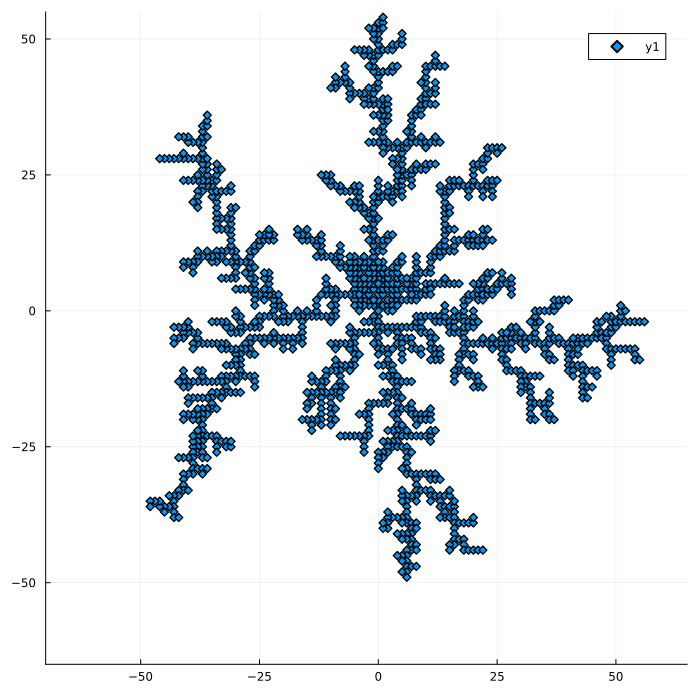

In [5]:
sticking_prob = 1.0
cluster_aggregate = readdlm("Final_Submission/raw_data/cluster aggregate for p = $sticking_prob.txt")

scatter(cluster_aggregate[1, : ], cluster_aggregate[2, :], xlims = (-70, 65), 
            ylims = (-65, 55), size = (700, 700), marker = :diamond )

savefig("Final_Submission/image_results/sample cluster aggregate.png")

scatter(cluster_aggregate[1, : ], cluster_aggregate[2, :], xlims = (-70, 65), 
            ylims = (-65, 55), size = (700, 700), marker = :diamond )

## KR1c: Benchmark

Rather than benchmark just the final function `Random_walker.serialized_dla(args)`, we benchmark the pertinent functions it uses.

#### Benchmarking for `initialize_randomwalker` function

In [6]:
birth_circle = rand(Uniform(1, 10))

@benchmark Random_walker.initialize_randomwalker($birth_circle)

BenchmarkTools.Trial: 10000 samples with 979 evaluations.
 Range (min … max):   62.615 ns …  22.547 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      81.410 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   107.413 ns ± 291.588 ns  ┊ GC (mean ± σ):  4.83% ± 3.71%

  █▅▂▃▆▃▁▄▃▄▃▂▂▂▃▄▃▁                                            ▁
  ████████████████████▇▇▇▇▇▇▆▆▆▆▅▄▅▆▅█▅▆▅▆▅▂▃▃▅▃▄▃▄▅▄▃▅▄▂▃▄▄▅▄▃ █
  62.6 ns       Histogram: log(frequency) by time        373 ns <

 Memory estimate: 80 bytes, allocs estimate: 1.

#### Benchmarking for `walker_update_position` function

In [7]:
birth_circle = rand(Uniform(1, 10))
death_circle = rand(Uniform(10, 15))

@benchmark Random_walker.walker_update_position(Random_walker.initialize_randomwalker($birth_circle), $death_circle, $birth_circle)

BenchmarkTools.Trial: 10000 samples with 460 evaluations.
 Range (min … max):  231.957 ns …  11.819 μs  ┊ GC (min … max): 0.00% … 96.94%
 Time  (median):     294.130 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   347.326 ns ± 463.100 ns  ┊ GC (mean ± σ):  7.35% ±  5.61%

  █▇▆▅▄▃▇▆▄▂▃▃▄▃▃▄▂▂▁▁▁▁ ▁▁▁▂▂▁      ▁▂▃▂▁                      ▂
  ██████████████████████████████████████████▇▇▇▅▆▇▆▆▄▆▃▆▅▅▅▁▅▅▅ █
  232 ns        Histogram: log(frequency) by time        852 ns <

 Memory estimate: 400 bytes, allocs estimate: 5.

#### Benchmarking for `random_walk_generator` function

In [8]:
step_number = 10000
death_radius = rand(Uniform(10, 15))
birth_radius = rand(Uniform(1, 10))

@benchmark Random_walker.random_walk_generator(step_number, $death_radius, $birth_radius)

BenchmarkTools.Trial: 1947 samples with 1 evaluation.
 Range (min … max):  1.803 ms … 8.509 ms  ┊ GC (min … max): 0.00% … 52.14%
 Time  (median):     2.181 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.551 ms ± 1.030 ms  ┊ GC (mean ± σ):  8.67% ± 14.51%

  █▆▆▆▆▄▅▄▃▄▃▃▃▂▂▁▂ ▁ ▁ ▁▁                                  ▁
  ████████████████████████▇▅▆▄▅▅▁▁▄▅▆▇██▇▇▆▆▆▄▇▇▅▆▆▄▅▅▁▆▆▆▅ █
  1.8 ms      Histogram: log(frequency) by time     6.66 ms <

 Memory estimate: 3.21 MiB, allocs estimate: 40043.

#### Benchmarking for `walker_distance_from_cluster` function

In [9]:
particle_number = 1500
cluster_particle_number = 1490
birth_radius = rand(Uniform(0, 20))
cluster_aggregate = rand(Uniform(0, 10), (2, particle_number))


@benchmark Random_walker.walker_distance_from_cluster($cluster_aggregate, 
        $Random_walker.initialize_randomwalker($birth_radius), cluster_particle_number)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  12.100 μs …  3.075 ms  ┊ GC (min … max): 0.00% … 97.45%
 Time  (median):     19.550 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.227 μs ± 56.312 μs  ┊ GC (mean ± σ):  4.70% ±  2.17%

  █▅▄▄▄▄▅▅▆▄▃▃▄▂▂▂▁▁▁▁▁▂▁▁▂     ▁                             ▂
  █████████████████████████▇▆▇▇▇██▇▇▆▅▆▅▆▇▄▅▅▅▅▄▅▅▅▅▅▄▄▂▄▃▄▃▄ █
  12.1 μs      Histogram: log(frequency) by time        90 μs <

 Memory estimate: 35.41 KiB, allocs estimate: 7.

#### Benchmarking for `cluster_distance_from_origin` function

In [10]:
particle_number = 1500
cluster_particle_number = 1490
cluster_aggregate = rand(Uniform(0, 10), (2, particle_number))

@benchmark Random_walker.cluster_distance_from_origin($cluster_aggregate, cluster_particle_number)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  11.100 μs …  5.941 ms  ┊ GC (min … max): 0.00% … 99.02%
 Time  (median):     16.300 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.096 μs ± 75.394 μs  ┊ GC (mean ± σ):  6.27% ±  2.18%

  █▄▃▃▃▂▁▁▁▃▄▅▃▂▂▃▃▂▂▃▂▁▁▁▁▁▁▁▁                               ▁
  ██████████████████████████████████▇▇▇▇▆▆▆▅█▇▆▅▆▅▆▆▅▄▅▅▅▄▄▄▄ █
  11.1 μs      Histogram: log(frequency) by time      68.1 μs <

 Memory estimate: 35.30 KiB, allocs estimate: 3.

# KR2: DLA Parallelised Implementation

## KR2a: `.jl` functions

A set of functions that generates multiple random walkers that can simultaneously perform a random walk across the square lattice.

## KR2b: Implementation

Parallel versin of the DLA algorithm by releasing multiple particles in the square lattice:
- GPU parallel computing, or
- parallel processing of the random walk trajectories

## KR2c: Benchmark

# KR3: Serial vs Parallelised Implementation

Plot of computational time vs number of random walkers (cluster size).

### Time Complexity of Serial Implementation

Run the following code only if there is no data yet.

In [15]:
# Generate array and save
# init_particle_number = 5000
# final_particle_number = 5000
# steps = 500
# for i = init_particle_number:steps:final_particle_number
#     particle_number = i
#     serial_time = time_complexity.run_time_serial(particle_number,100.0,1.0)
#     writedlm("raw_data/serial_time particle_number = $particle_number.txt", serial_time)
# end

All the cells below are run for plotting.

In [16]:
# Compile serial_time array into one
serial_run_time = zeros(9,4)
init_particle_number = 500
final_particle_number = 4500
steps = 500
for i = init_particle_number:steps:final_particle_number
    particle_number = i
    serial_time = readdlm("raw_data/serial_time particle_number = $particle_number.txt")
    j = Int(i/steps)
    serial_run_time[j,:] = serial_time
end

In [17]:
# Obtain stats array
serial_run_time_stats = time_complexity.run_time_stats(serial_run_time)

9×3 Matrix{Float64}:
  500.0    1.21091    0.460901
 1000.0   10.273      1.74755
 1500.0   40.4775    23.0147
 2000.0   74.8837    10.1176
 2500.0  135.924     33.6169
 3000.0  117.953     50.0148
 3500.0  186.419     57.6462
 4000.0  183.62      63.1646
 4500.0  304.239    185.3

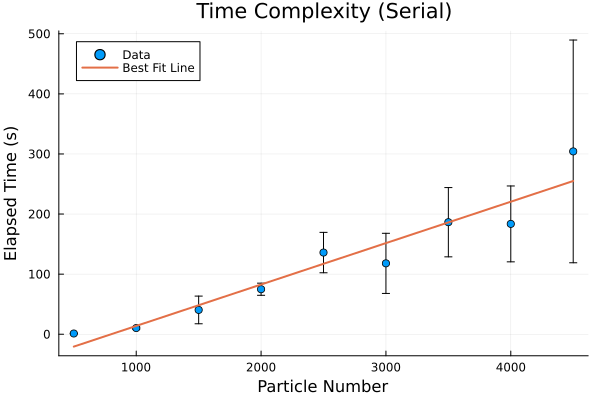

In [18]:
x_stats_serial = serial_run_time_stats[:,1]
y_stats_serial = serial_run_time_stats[:,2]
se_serial = serial_run_time_stats[:,3]
data = DataFrame(x = x_stats_serial, y = y_stats_serial)
model = lm(@formula(y ~ x), data)
intercept, slope = coef(model)

y_best_serial = intercept .+ slope .* x_stats_serial
scatter(x_stats_serial, y_stats_serial, yerror=se_serial, 
    label = "Data", 
    xlabel = "Particle Number", ylabel = "Elapsed Time (s)", 
    title = "Time Complexity (Serial)")
plot!(x_stats_serial, y_best_serial, label = "Best Fit Line", lw = 2)

### Time Complexity of Parallelised Implementation

Run the following code only if there is no data yet.

In [19]:
# Generate array and save
# init_particle_number = 2000
# final_particle_number = 5000
# steps = 500
# for i = init_particle_number:steps:final_particle_number
#     particle_number = i
#     parallel_time = time_complexity.run_time_parallel(particle_number,0.8,10000,150,300,1)
#     writedlm("raw_data/parallel_time particle_number = $particle_number.txt", parallel_time)
# end

All the cells below are run for plotting.

In [20]:
# Compile serial_time array into one
parallel_run_time = zeros(9,4)
init_particle_number = 500
final_particle_number = 4500
steps = 500
for i = init_particle_number:steps:final_particle_number
    particle_number = i
    parallel_time = readdlm("raw_data/parallel_time particle_number = $particle_number.txt")
    j = Int(i/steps)
    parallel_run_time[j,:] = parallel_time
end

In [21]:
# Obtain stats array
parallel_run_time_stats = time_complexity.run_time_stats(parallel_run_time)

9×3 Matrix{Float64}:
  500.0    1.76947   0.472818
 1000.0    7.88304   1.54448
 1500.0   26.4863   10.0599
 2000.0   56.7727   14.703
 2500.0   93.7327   38.1226
 3000.0  139.604    12.1455
 3500.0  214.951    60.1342
 4000.0  230.33     32.9168
 4500.0  403.689    59.3837

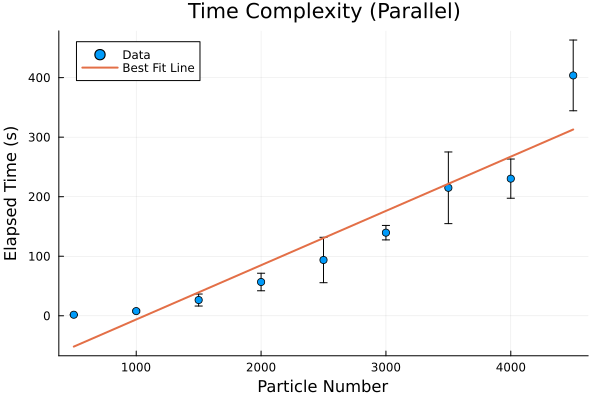

In [22]:
x_stats_parallel = parallel_run_time_stats[:,1]
y_stats_parallel = parallel_run_time_stats[:,2]
se_parallel = parallel_run_time_stats[:,3]
data = DataFrame(x = x_stats_parallel, y = y_stats_parallel)
model = lm(@formula(y ~ x), data)
intercept, slope = coef(model)

y_best_parallel = intercept .+ slope .* x_stats_parallel
scatter(x_stats_parallel, y_stats_parallel, yerror=se_parallel, 
    label = "Data", 
    xlabel = "Particle Number", ylabel = "Elapsed Time (s)", 
    title = "Time Complexity (Parallel)")
plot!(x_stats_parallel, y_best_parallel, label = "Best Fit Line", lw = 2)

### Time Complexity Log-Log Plot (Serial vs Parallelised)

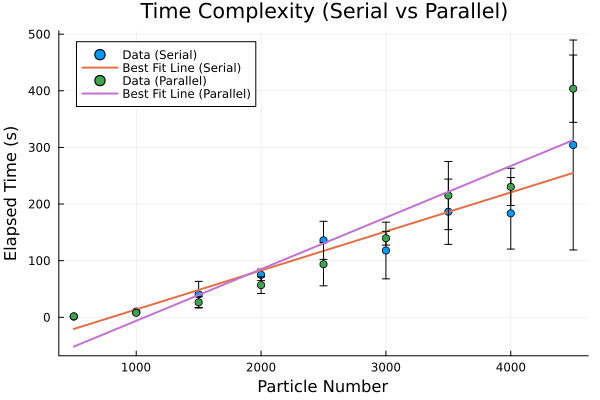

In [23]:
scatter(x_stats_serial, y_stats_serial, yerror=se_serial, 
    label = "Data (Serial)", 
    xlabel = "Particle Number", ylabel = "Elapsed Time (s)", 
    title = "Time Complexity (Serial vs Parallel)")
plot!(x_stats_serial, y_best_serial, label = "Best Fit Line (Serial)", lw = 2)
scatter!(x_stats_parallel, y_stats_parallel, yerror=se_parallel, 
    label = "Data (Parallel)", 
    xlabel = "Particle Number", ylabel = "Elapsed Time (s)")
plot!(x_stats_parallel, y_best_parallel, label = "Best Fit Line (Parallel)", lw = 2)

In [24]:
savefig("image_results/time complexity plot.png")

"/Users/marick/Documents/Phys_215/phy215-final/Final_Submission/image_results/time complexity plot.png"

# KR4: Fractality of Clusters

## KR4a: `.jl` functions

Function for calculating the mass function of the cluster.

In [25]:
? fractal_dimension.mass_per_radius()

# Description

Calculates the number of particles in a fractal per radius r = 5:5:30.  Returns a 6x2 array where the first column contains the radii and the second columns contains the masses.

## Args

```
cluster_aggregate (Matrix{Float64}): The input fractal whose dimension is to be calculated.
```

## Returns

```
[radiusArray mass_per_radius] (Matrix{Float64}): Mass per radius
```


## KR4b: Fractal Dimension

Estimate the fractal dimension.

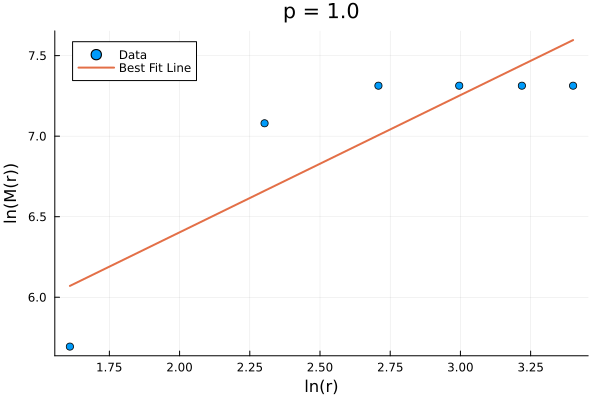

In [11]:
matrix = fractal_dimension.mass_per_radius(cluster_aggregate)
x = log.(matrix[:, 1])
y = log.(matrix[:, 2])

data = DataFrame(x = x, y = y)
model = lm(@formula(y ~ x), data)
intercept, slope = coef(model)

scatter(x, y, label = "Data", xlabel = "ln(r)", ylabel = "ln(M(r))", title = "p = $sticking_prob")
plot!(x, intercept .+ slope .* x, label = "Best Fit Line", lw = 2)

In [13]:
savefig("Final_Submission/image_results/log-log plot p = $sticking_prob.png")

"c:\\Users\\User\\Desktop\\PHYSICS RESOURCES\\PHYSICS 215 (HPC Julia)\\Final Project\\phy215-final\\Final_Submission\\image_results\\log-log plot p = 1.0.png"

In [14]:
println("The slope (fractal dimension) is equal to $slope")

The slope (fractal dimension) is equal to 0.8517062969189609
